# Generate a dataset, and train a model

## General Imports

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


2023-05-11 09:38:10.284020: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Generate Dataset

In [3]:
import pose_parser.jobs.build_and_format_dataset_job as data_builder 

# Set I/O
# where the sequence data generated from keypoints live
sequence_data_directory = "../../data/sequences/run-preproccessed-1680117203184086000"
# where the source annotations live
source_annotations_directory = "../../source_annotations"
# where the datasets live
merged_annotation_output_directory = "../../data/annotated_videos"


db = data_builder.BuildAndFormatDatasetJob()
dataset = db.build_dataset_from_data_files(
    annotations_data_directory=source_annotations_directory,
    sequence_data_directory=sequence_data_directory,
    limit=None,
)

formatted_dataset = db.format_dataset(
    dataset=dataset,
    pool_frame_data_by_clip=False,
    decimal_precision=4,
    include_unlabeled_data=True,
    include_angles=True,
    include_distances=True,
    include_normalized=True,
    segmentation_strategy="flatten_into_columns",
    segmentation_splitter_label="step_type",
    segmentation_window=10,
    segmentation_window_label="weight_transfer_type",
)

db.write_dataset_to_csv(
    csv_location=merged_annotation_output_directory,
    formatted_dataset=formatted_dataset,
    filename="preprocessed_flatten_on_example_10_frames"
)

True

## Train Model

Training Balance for weight_transfer_type:
0    2410
1    2410
Name: weight_transfer_type, dtype: int64
Mean ROC AUC from cross validation: 1.000
Min ROC AUC from cross validation: 1.000
Max ROC AUC from cross validation: 1.000
Classification Metrics:
Accuracy: 0.9048
Precision: 0.9161
Recall: 0.9784
F1 Score: 0.9463
ROC AUC: 0.9082
Matthews correlation coefficient (-1 to 1): 0.5571549693620687

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.47      0.58       101
           1       0.92      0.98      0.95       603

    accuracy                           0.90       704
   macro avg       0.85      0.72      0.77       704
weighted avg       0.90      0.90      0.89       704



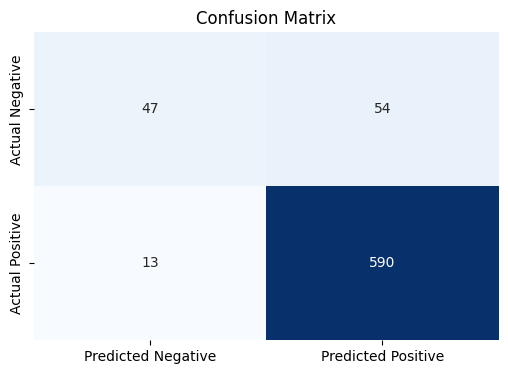

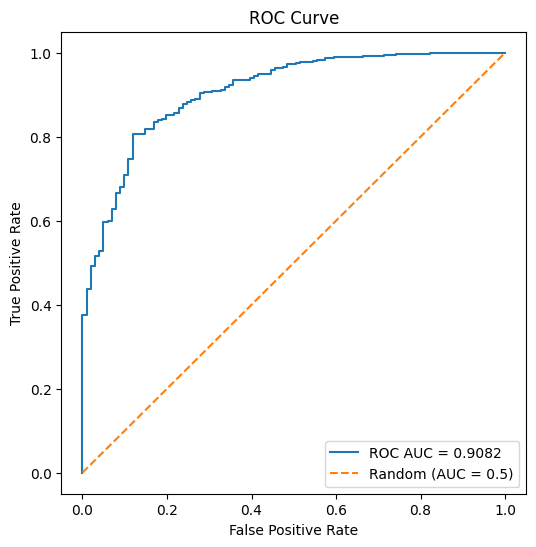

In [6]:
from pose_parser.learning import model_builder as mb

# Mapping string categories to numerical
value_map = {
    "weight_transfer_type": {
        "Failure Weight Transfer": 0,
        "Successful Weight Transfer": 1,
    },
    "step_type": {
        "Left Step": 0,
        "Right Step": 1,
    },
}
# Columns we know we'll always want to drop
drop_list = ["video_id"]
# Only keep these columns (including target)
column_whitelist = []

data_file = "../../data/annotated_videos/preprocessed_flatten_on_example_10_frames.csv"

model_builder = mb.ModelBuilder()

model_builder.load_and_prep_dataset_from_csv(
    path=data_file,
    target="weight_transfer_type",
    value_map=value_map,
    column_whitelist=column_whitelist,
    drop_list=drop_list,
)

model_builder.set_train_test_split(
    balance_off_target=True,
    upsample_minority=True,
    downsample_majority=False,
    use_SMOTE=False,
    random_state=40002,
)
model_builder.train_gradient_boost()
model_builder.evaluate_model()

## Save Model + Metadata

In [7]:
""" WRITE NOTES ON THIS RUN HERE """
notes = """
Gradient Boost classifier (90% ROC AUC) trained on dataset preprocessed_flatten_on_example_10_frames, a 10 frame window with flat column 2d angles + distances, and randomly upsampled
    """

model_builder.save_model_and_datasets(notes=notes, model_type="gradient-boost")

Saved model to pickle!
